**More Naiive but improved algorithm**

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical

def load_and_convert_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error loading image: {image_path}")
        return None, None
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image, gray_image


# Edge detection functions
def sobel_edge_detection(gray_image):
    sobel_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=3)
    return cv2.magnitude(sobel_x, sobel_y)

def canny_edge_detection(gray_image, low_threshold=100, high_threshold=200):
    return cv2.Canny(gray_image, low_threshold, high_threshold)

def log_edge_detection(gray_image):
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
    return cv2.Laplacian(blurred_image, cv2.CV_64F)

# Contour extraction
def find_contours(edge_image):
    edge_image = cv2.convertScaleAbs(edge_image)
    contours, _ = cv2.findContours(edge_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

# Feature extraction from contours
def calculate_shape_features(image, contours):
    features = []
    labels = []  # Placeholder for manual or model-generated labels

    for contour in contours:
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.04 * perimeter, True)
        vertices = len(approx)

        # Pixel count
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)
        pixel_count = cv2.countNonZero(mask)

        features.append([area, perimeter, vertices, pixel_count])
        # Auto-label for testing purposes
        labels.append(auto_label_shape(contour))

    return np.array(features), np.array(labels)

# Auto-label shapes
def auto_label_shape(contour):
    perimeter = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.04 * perimeter, True)
    vertices = len(approx)
    area = cv2.contourArea(contour)

    if area < 10 and vertices < 4:
        return 'Unknown'
    if vertices > 5:
        circularity = 4 * np.pi * area / (perimeter ** 2)
        if circularity > 0.8:
            return 'Circle'
    if vertices == 3:
        return 'Triangle'
    if vertices == 4:
        rect = cv2.boundingRect(approx)
        width, height = rect[2], rect[3]
        if 0.9 <= width / height <= 1.1:
            return 'Square'
        return 'Rectangle'
    return 'Polygon'

# Prepare kNN data
def prepare_knn_data(features, labels):
    return np.array(features), np.array(labels)

# Train and evaluate kNN
def train_and_evaluate_knn(features, labels):
    X, y = prepare_knn_data(features, labels)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    return knn

# Deep Learning Model
def build_and_train_cnn(X_train, y_train, X_test, y_test, num_classes):
    model = Sequential([
        Flatten(input_shape=X_train.shape[1:]),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
    return model

# Main function
def main():
    image_paths = ['images/simple_circle.jpeg', 'images/simple_square.webp', 'images/simple_triangle.jpg',
                   'images/simple_yin_and_yang.jpg', 'images/medium_flower.jpg', 'images/medium_miata.jpeg',
                   'images/medium_traffic_lights.jpg', 'images/polar_bear_hard.webp', 'images/city_scape_hard.jpeg',
                   'images/airplane_hard.jpg']

    output_folder = 'final_images'
    os.makedirs(output_folder, exist_ok=True)
    all_features, all_labels = [], []

    for image_path in image_paths:
        image, gray_image = load_and_convert_image(image_path)
        canny_edges = canny_edge_detection(gray_image)
        contours = find_contours(canny_edges)
        features, labels = calculate_shape_features(image, contours)
        all_features.extend(features)
        all_labels.extend(labels)

    X, y = np.array(all_features), np.array(all_labels)
    train_and_evaluate_knn(X, y)

    # Deep learning approach
    y_encoded = to_categorical([0 if label == 'Circle' else 1 for label in y])
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
    build_and_train_cnn(X_train, y_train, X_test, y_test, num_classes=2)

if __name__ == "__main__":
    main()

Error loading image: images/simple_square.webp
Error loading image: images/polar_bear_hard.webp
Confusion Matrix:
[[  0   2   0   0   0   0]
 [  0 216   7   0   1   2]
 [  1  20  44   0   0   8]
 [  0   0   2  10   0   0]
 [  0   3   2   0   0   0]
 [  0   8   2   1   0 207]]

Classification Report:
              precision    recall  f1-score   support

      Circle       0.00      0.00      0.00         2
     Polygon       0.87      0.96      0.91       226
   Rectangle       0.77      0.60      0.68        73
      Square       0.91      0.83      0.87        12
    Triangle       0.00      0.00      0.00         5
     Unknown       0.95      0.95      0.95       218

    accuracy                           0.89       536
   macro avg       0.58      0.56      0.57       536
weighted avg       0.88      0.89      0.88       536

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9940 - loss: 4.2227 - val_accuracy: 0.9963 - val_loss: 0.0568
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 51.7128 - val_accuracy: 0.9963 - val_loss: 0.0445
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9910 - loss: 8.1412 - val_accuracy: 0.9944 - val_loss: 3.9325
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9964 - loss: 1.6526 - val_accuracy: 0.9963 - val_loss: 0.0745
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9978 - loss: 1.2432 - val_accuracy: 0.9963 - val_loss: 0.0689
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9978 - loss: 59.5074 - val_accuracy: 0.9944 - val_loss: 5.8084
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 4.4999 - val_accuracy: 0.9944 - val_loss: 2.3310
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 2.9421 - val_accuracy: 0.9963 - val_loss: 0.0686
E

**Using the actual Dataset and more advanced training given by:...**

Found 100000 files belonging to 200 classes.
Found 10000 files belonging to 200 classes.
Class names: ['n01443537', 'n01629819', 'n01641577', 'n01644900', 'n01698640', 'n01742172', 'n01768244', 'n01770393', 'n01774384', 'n01774750', 'n01784675', 'n01855672', 'n01882714', 'n01910747', 'n01917289', 'n01944390', 'n01945685', 'n01950731', 'n01983481', 'n01984695', 'n02002724', 'n02056570', 'n02058221', 'n02074367', 'n02085620', 'n02094433', 'n02099601', 'n02099712', 'n02106662', 'n02113799', 'n02123045', 'n02123394', 'n02124075', 'n02125311', 'n02129165', 'n02132136', 'n02165456', 'n02190166', 'n02206856', 'n02226429', 'n02231487', 'n02233338', 'n02236044', 'n02268443', 'n02279972', 'n02281406', 'n02321529', 'n02364673', 'n02395406', 'n02403003', 'n02410509', 'n02415577', 'n02423022', 'n02437312', 'n02480495', 'n02481823', 'n02486410', 'n02504458', 'n02509815', 'n02666196', 'n02669723', 'n02699494', 'n02730930', 'n02769748', 'n02788148', 'n02791270', 'n02793495', 'n02795169', 'n02802426', 

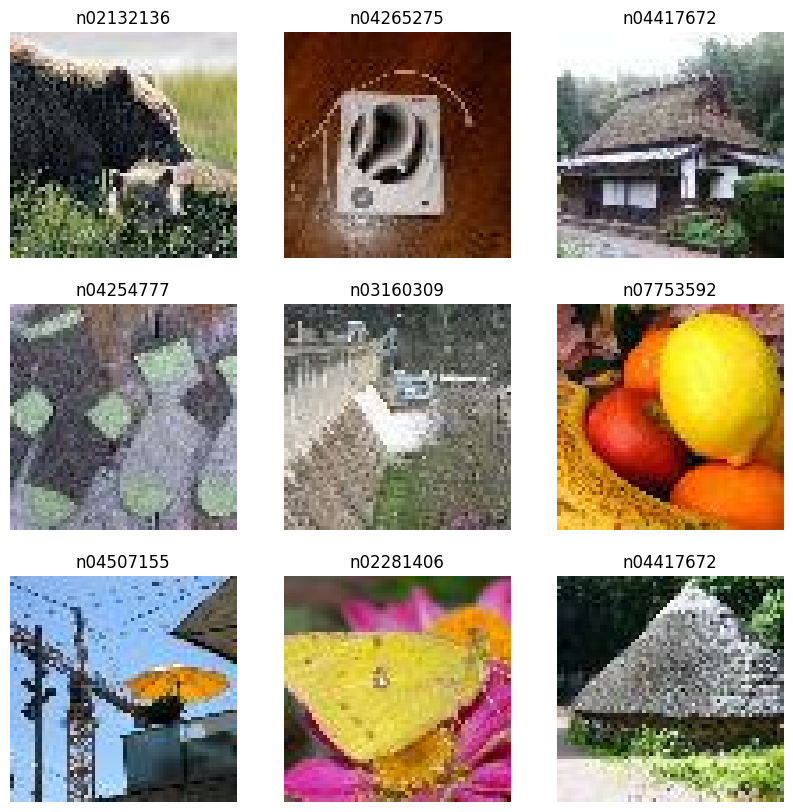

In [5]:
import os
import zipfile
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt

# Paths
zip_path = "tiny_imagenet/tiny-imagenet-200.zip"  # Update to your ZIP file path
extract_dir = "tiny_imagenet/tiny-imagenet-200"
train_dir = os.path.join(extract_dir, "train")
val_dir = os.path.join(extract_dir, "val")
reorganized_val_dir = os.path.join(extract_dir, "reorganized_val")

# Step 1: Unzip the dataset
if not os.path.exists(extract_dir):
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall("tiny_imagenet")
    print(f"Dataset extracted to: {extract_dir}")

# Step 2: Reorganize the validation dataset
if not os.path.exists(reorganized_val_dir):
    os.makedirs(reorganized_val_dir, exist_ok=True)
    val_images_dir = os.path.join(val_dir, "images")
    val_annotations_file = os.path.join(val_dir, "val_annotations.txt")

    # Read annotations to map images to classes
    with open(val_annotations_file, "r") as f:
        lines = f.readlines()

    for line in lines:
        parts = line.strip().split("\t")
        image_name, class_name = parts[0], parts[1]

        # Create a directory for the class if it doesn't exist
        class_dir = os.path.join(reorganized_val_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)

        # Move the image to the appropriate class directory
        src_path = os.path.join(val_images_dir, image_name)
        dst_path = os.path.join(class_dir, image_name)
        if os.path.exists(src_path):  # Check if the file exists
            shutil.move(src_path, dst_path)

    print(f"Validation folder reorganized to: {reorganized_val_dir}")

# Step 3: Load the datasets (limit the number of images loaded)
train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=(64, 64),  # Tiny ImageNet images are 64x64
    batch_size=32,
    label_mode="int",
)

val_dataset = image_dataset_from_directory(
    reorganized_val_dir,
    image_size=(64, 64),
    batch_size=32,
    label_mode="int",
)

# Access class names before applying take
class_names = train_dataset.class_names
print("Class names:", class_names)

# Limit the number of images processed
train_dataset = train_dataset.take(500)  # For example, use only 500 batches (16,000 images)
val_dataset = val_dataset.take(100)  # For example, use only 100 batches (3,200 images)

# Step 4: Preprocess the images (normalize to [0, 1])
def preprocess_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_dataset = train_dataset.map(preprocess_image)
val_dataset = val_dataset.map(preprocess_image)

# Step 5: Feature extraction (e.g., Sobel edge detection)
def extract_features(images):
    # Ensure images are in [0, 1] range and have batch dimension
    sobel_images = []
    for image in images:
        image = tf.expand_dims(image, axis=0)  # Add batch dimension
        sobel_image = tf.image.sobel_edges(image)  # Sobel edge detection
        sobel_image = tf.squeeze(sobel_image)  # Remove batch dimension
        flattened = tf.reshape(sobel_image, [-1])  # Flatten to 1D
        sobel_images.append(flattened.numpy())
    return np.array(sobel_images)

# Step 6: Prepare data for kNN
X_train, y_train = [], []
for images, labels in train_dataset:
    features = extract_features(images)
    X_train.extend(features)
    y_train.extend(labels.numpy())
X_train, y_train = np.array(X_train), np.array(y_train)

X_val, y_val = [], []
for images, labels in val_dataset:
    features = extract_features(images)
    X_val.extend(features)
    y_val.extend(labels.numpy())
X_val, y_val = np.array(X_val), np.array(y_val)

# Step 7: Train a kNN model
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Step 8: Evaluate the model
y_pred = knn.predict(X_val)
accuracy = np.mean(y_pred == y_val)
print(f"Validation accuracy: {accuracy * 100:.2f}%")

# Step 9: Display a batch of images
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i].numpy()])  # Correctly map labels to class names
        plt.axis("off")
    plt.show()


Found 100000 files belonging to 200 classes.
Found 10000 files belonging to 200 classes.


<ipython-input-7-8a8fccfd5525>:80: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(64, 64, 3), include_top=False, weights="imagenet")


Found 100000 images belonging to 200 classes.
Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 104s 197ms/step - accuracy: 0.0889 - loss: 4.7420 - val_accuracy: 0.2244 - val_loss: 3.5420
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 89s 178ms/step - accuracy: 0.1842 - loss: 3.7812
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 98s 197ms/step - accuracy: 0.2150 - loss: 3.5883 - val_accuracy: 0.2606 - val_loss: 3.2761
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 131s 262ms/step - accuracy: 0.2337 - loss: 3.4955
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 99s 198ms/step - accuracy: 0.2378 - loss: 3.4394 - val_accuracy: 0.2778 - val_loss: 3.2011
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 130s 260ms/step - accuracy: 0.2453 - loss: 3.4270
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 28s 56ms/step - accuracy: 0.2318 - loss: 3.3946 - val_accuracy: 0.2766 - val_loss: 3.1916
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 92s 183ms/step - accuracy: 0.2481 - loss: 3.3655
Epoch 9/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 99s 198ms/step - accuracy: 0.252

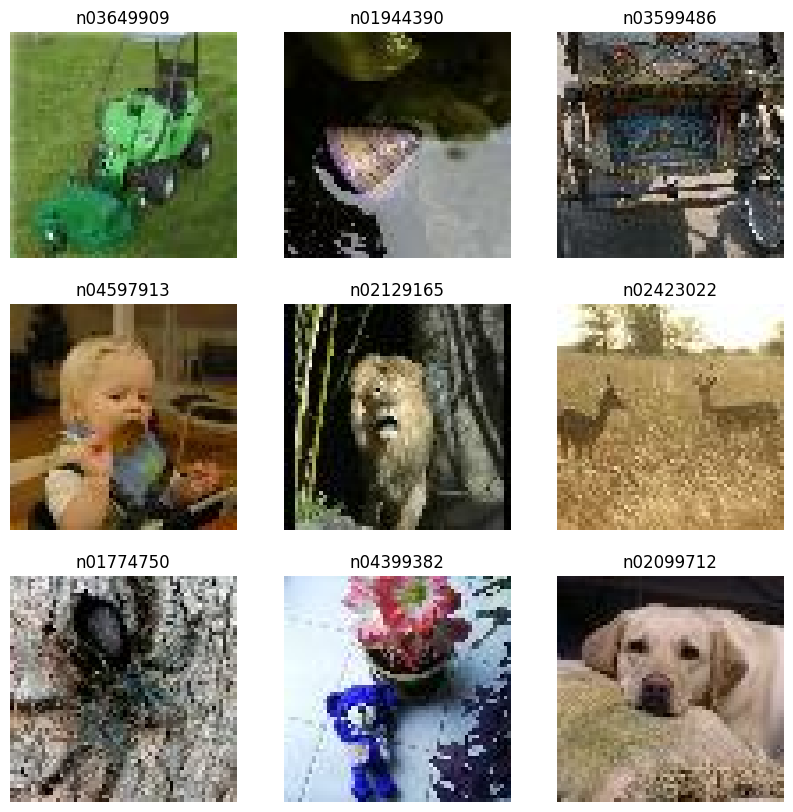

In [7]:
import os
import zipfile
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Paths
zip_path = "tiny_imagenet/tiny-imagenet-200.zip"  # Update to your ZIP file path
extract_dir = "tiny_imagenet/tiny-imagenet-200"
train_dir = os.path.join(extract_dir, "train")
val_dir = os.path.join(extract_dir, "val")
reorganized_val_dir = os.path.join(extract_dir, "reorganized_val")

# Step 1: Unzip the dataset
if not os.path.exists(extract_dir):
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall("tiny_imagenet")
    print(f"Dataset extracted to: {extract_dir}")

# Step 2: Reorganize the validation dataset
if not os.path.exists(reorganized_val_dir):
    os.makedirs(reorganized_val_dir, exist_ok=True)
    val_images_dir = os.path.join(val_dir, "images")
    val_annotations_file = os.path.join(val_dir, "val_annotations.txt")

    # Read annotations to map images to classes
    with open(val_annotations_file, "r") as f:
        lines = f.readlines()

    for line in lines:
        parts = line.strip().split("\t")
        image_name, class_name = parts[0], parts[1]

        # Create a directory for the class if it doesn't exist
        class_dir = os.path.join(reorganized_val_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)

        # Move the image to the appropriate class directory
        src_path = os.path.join(val_images_dir, image_name)
        dst_path = os.path.join(class_dir, image_name)
        if os.path.exists(src_path):  # Check if the file exists
            shutil.move(src_path, dst_path)

    print(f"Validation folder reorganized to: {reorganized_val_dir}")

# Step 3: Load the datasets (limit the number of images loaded)
train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=(64, 64),  # Tiny ImageNet images are 64x64
    batch_size=32,
    label_mode="int",  # Use int for sparse categorical labels
)

val_dataset = image_dataset_from_directory(
    reorganized_val_dir,
    image_size=(64, 64),
    batch_size=32,
    label_mode="int",
)

# Limit the number of images processed
train_dataset = train_dataset.take(500)  # For example, use only 500 batches (16,000 images)
val_dataset = val_dataset.take(100)  # For example, use only 100 batches (3,200 images)

# Step 4: Preprocess the images (normalize to [0, 1])
def preprocess_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_dataset = train_dataset.map(preprocess_image)
val_dataset = val_dataset.map(preprocess_image)

# Step 5: Define the model using MobileNetV2 as the base
base_model = MobileNetV2(input_shape=(64, 64, 3), include_top=False, weights="imagenet")
base_model.trainable = False  # Freeze the base model

# Add a custom head on top of the pre-trained base model
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation="relu")(x)
x = Dense(200, activation="softmax")(x)  # 200 classes in Tiny ImageNet
model = Model(inputs=base_model.input, outputs=x)

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Step 6: Data Augmentation (you can apply this directly in the `train_dataset`)
data_augmentation = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Step 7: Train the model with data augmentation (use train_dataset directly)
history = model.fit(
    data_augmentation.flow_from_directory(train_dir, target_size=(64, 64), batch_size=32, class_mode="sparse"),
    steps_per_epoch=len(train_dataset),
    epochs=10,
    validation_data=val_dataset,
    validation_steps=len(val_dataset),
)

# Step 8: Evaluate the model
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"Validation accuracy: {val_accuracy * 100:.2f}%")

# Step 9: Display a batch of images
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i].numpy()])  # Correctly map labels to class names
        plt.axis("off")
    plt.show()

Done
